[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/generation/langchain/handbook/xx-langchain-chunking.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/generation/langchain/handbook/xx-langchain-chunking.ipynb)

#### [LangChain Handbook](https://pinecone.io/learn/langchain)

# Preparing Text Data for use with Retrieval-Augmented LLMs

In this walkthrough we'll take a look at an example and some of the considerations when we need to prepare text data for retrieval augmented question-answering using **L**arge **L**anguage **M**odels (LLMs).

## Required Libraries

There are a few Python libraries we must `pip install` for this notebook to run, those are:

In [ ]:
!pip install -qU langchain tiktoken matplotlib seaborn tqdm

## Preparing Data

In this example, we will download the LangChain docs from [langchain.readthedocs.io/](https://langchain.readthedocs.io/latest/en/). We get all `.html` files located on the site like so:

In [4]:
# !wget -r -l inf -A.html -D www.mun.ca -I /university-calendar/general-information/ -P rtdocs_3 https://www.mun.ca/university-calendar/general-information/

In [5]:
# import os
# import tiktoken

# # Define the directory containing your .txt files
# txt_directory = 'data_train'

# # Function to read text file
# def read_text_file(file_path):
#     with open(file_path, 'r') as file:
#         return file.read()

# # Loading text content from txt files
# docs = []
# for file in os.listdir(txt_directory):
#     if file.endswith('.txt'):
#         file_path = os.path.join(txt_directory, file)
#         text_content = read_text_file(file_path)
#         docs.append({'page_content': text_content, 'metadata': {'source': file_path}})

# # Initialize the tiktoken tokenizer
# tokenizer = tiktoken.get_encoding('cl100k_base')

# # Function to count tokens
# def tiktoken_len(text):
#     tokens = tokenizer.encode(
#         text,
#         disallowed_special=()
#     )
#     return len(tokens)

# # Count tokens for each document
# token_counts = [tiktoken_len(doc['page_content']) for doc in docs]

# # Print min, average, and max token counts
# print(f"""Min: {min(token_counts)}
# Avg: {int(sum(token_counts) / len(token_counts))}
# Max: {max(token_counts)}""")

# # Visualization
# import matplotlib.pyplot as plt
# import seaborn as sns

# sns.set_style("whitegrid")
# sns.set_palette("muted")

# plt.figure(figsize=(12, 6))
# sns.histplot(token_counts, kde=False, bins=50)
# plt.title("Token Counts Histogram")
# plt.xlabel("Token Count")
# plt.ylabel("Frequency")
# plt.show()


This downloads all HTML into the `rtdocs` directory. Now we can use LangChain itself to process these docs. We do this using the `ReadTheDocsLoader` like so:

In [1]:
from langchain.document_loaders import ReadTheDocsLoader

loader = ReadTheDocsLoader('rtdocs_1')
docs = loader.load()
len(docs)

KeyboardInterrupt: 

This leaves us with `389` processed doc pages. Let's take a look at the format each one contains:

In [58]:
docs[2]

{'page_content': 'Copyright © 2023 Memorial University of Newfoundland.Newfoundland and Labrador, Canada.calendar.editor@mun.caLoading course...6.3Bachelor of Physical EducationIn this sectionOn this pageThe Bachelor of Physical Education may be completed on a full-time or part-time basis and requires 120 credit hours as outlined inBachelor of Physical Education.This program is offered in the Teaching and General degrees.Critical Reading and Writing (CRW)courses are regulated by the Faculty of Humanities and Social Sciences. Eligible CRW courses are indicated under Faculty of Humanities and Social Sciences,Course Descriptions.A student is encouraged to consider the honours regulations outlined underHonours Degree.Bachelor of Physical EducationRequired Non-HKR Courses(27 Credit Hours)Required HKR Courses(63 Credit Hours)Elective Courses(30 credit hours)3 credit hours in aCritical Reading and Writing (CRW)designated courseEnglish1090or1000Mathematics1000and 3 credit hours in an elective 

We access the plaintext page content like so:

In [12]:
print(docs[10]['page_content'])

Copyright © 2023 Memorial University of Newfoundland.Newfoundland and Labrador, Canada.calendar.editor@mun.caLoading course...2Student Code of ConductIn this sectionOn this pageMemorial University of Newfoundland expects that students will conduct themselves in compliance with University Regulations and Policies, Departmental Policies, and Federal, Provincial and Municipal laws, as well as codes of ethics that govern students who are members of regulated professions. TheStudent Code of Conductoutlines the behaviours that the University considers to be non-academic misconduct offences and the range of remedies and/or penalties that may be imposed. Academic misconduct is outlined inUniversity Regulations (Undergraduate), Academic Misconduct. Professional Suitability is outlined inUniversity Regulations (Undergraduate), Professional Suitability.


In [9]:
print(docs[5].page_content)

We can also find the source of each document:

In [56]:
docs[201].metadata['source'].replace('rtdocs_1/', 'https://www.mun.ca/university-calendar/')

AttributeError: 'dict' object has no attribute 'metadata'

Looks good, we need to also consider the length of each page with respect to the number of tokens that will reasonably fit within the window of the latest LLMs. We will use `gpt-3.5-turbo` as an example.

To count the number of tokens that `gpt-3.5-turbo` will use for some text we need to initialize the `tiktoken` tokenizer.

In [28]:
from pathlib import Path
from bs4 import BeautifulSoup
import tiktoken

# Define the root directory containing your .html files
root_directory = Path('rtdocs_1')

# Function to read and parse HTML file
def read_and_parse_html(file_path):
    with open(file_path, 'r') as file:  # added encoding for safety
        soup = BeautifulSoup(file.read(), 'html.parser')
        content_div = soup.find('div', id='sb-content-inside')
        return content_div.get_text(strip=True) if content_div else ''

# Recursively find all HTML files and process them
docs = []
for html_file in root_directory.rglob('*.html'):
    content = read_and_parse_html(html_file)
    if content:
        docs.append({'page_content': content})

# Initialize the tiktoken tokenizer
tokenizer = tiktoken.get_encoding('cl100k_base')

# Function to count tokens
def tiktoken_len(text):
    tokens = tokenizer.encode(text, disallowed_special=())
    return len(tokens)

# Count tokens for each document
token_counts = [tiktoken_len(doc['page_content']) for doc in docs]

# Print min, average, and max token counts
if token_counts:
    print(f"Min: {min(token_counts)}")
    print(f"Avg: {int(sum(token_counts) / len(token_counts))}")
    print(f"Max: {max(token_counts)}")
else:
    print("No tokens found. Check if the HTML files are correctly parsed.")

# Visualization (as before)


Min: 43
Avg: 1044
Max: 15262


In [36]:
## Extracts the elements with the specified class from the webpage

import requests
from bs4 import BeautifulSoup

# URL of the webpage
url = 'https://www.mun.ca/university-calendar/st-johns-campus/faculty-of-science/11/11/'

# Fetch the webpage
response = requests.get(url)

# Parse the HTML
soup = BeautifulSoup(response.content, 'html.parser')

# Find all elements with the same class
elements = soup.find_all('div', id_='calendar-section')  # Replace 'div' and 'your-class-name' with the actual tag and class

# Initialize an empty string or list to store the extracted content
extracted_content = ""

# Iterate over elements and extract text
for element in elements:
    extracted_content += element.get_text() + "\n"  # Append each element's text to the string

# Now 'extracted_content' contains all the text from the elements with the specified class
print(extracted_content)


In [15]:
# import tiktoken

# tokenizer = tiktoken.get_encoding('cl100k_base')

# # create the length function
# def tiktoken_len(text):
#     tokens = tokenizer.encode(
#         text,
#         disallowed_special=()
#     )
#     return len(tokens)

Note that for the tokenizer we defined the encoder as `"cl100k_base"`. This is a specific tiktoken encoder which is used by `gpt-3.5-turbo`. Other encoders exist. At the time of writing the OpenAI specific tokenizers (using `tiktoken`) are summarized as:

| Encoder | Models |
| --- | --- |
| `cl100k_base` | `gpt-4`, `gpt-3.5-turbo`, `text-embedding-ada-002` |
| `p50k_base` | `text-davinci-003`, `code-davinci-002`, `code-cushman-002` |
| `r50k_base` | `text-davinci-001`, `davinci`, `text-similarity-davinci-001` |
| `gpt2` | `gpt2` |

You can find these details in the [Tiktoken `model.py` script](https://github.com/openai/tiktoken/blob/main/tiktoken/model.py), or using `tiktoken.encoding_for_model`:

In [2]:
tiktoken.encoding_for_model('gpt-3.5-turbo')

<Encoding 'cl100k_base'>

Using the `tiktoken_len` function, let's count and visualize the number of tokens across our webpages.

In [17]:
# token_counts = [tiktoken_len(doc.page_content) for doc in docs]

Let's see `min`, average, and `max` values:

In [18]:
# print(f"""Min: {min(token_counts)}
# Avg: {int(sum(token_counts) / len(token_counts))}
# Max: {max(token_counts)}""")

Min: 0
Avg: 0
Max: 0


Now visualize:

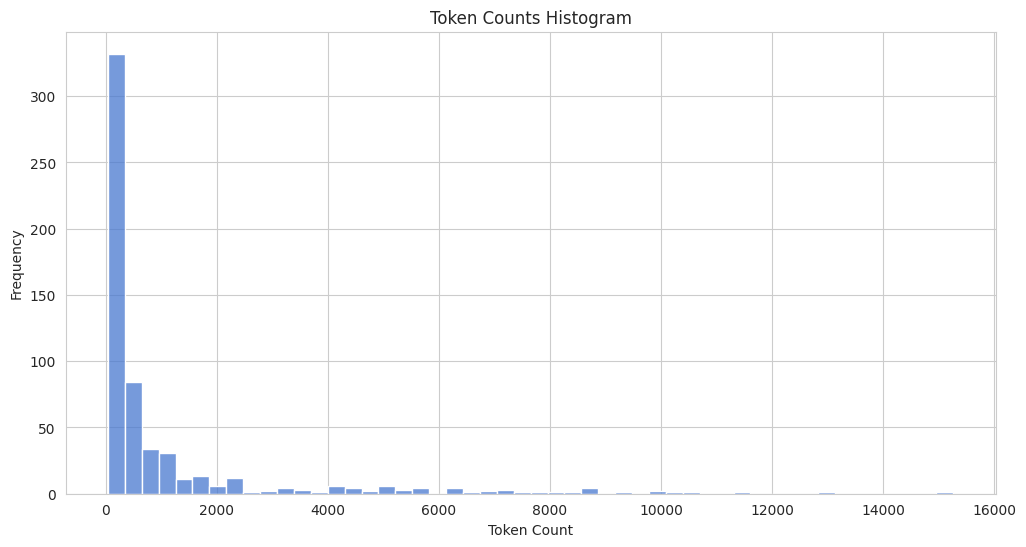

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# set style and color palette for the plot
sns.set_style("whitegrid")
sns.set_palette("muted")

# create histogram
plt.figure(figsize=(12, 6))
sns.histplot(token_counts, kde=False, bins=50)

# customize the plot info
plt.title("Token Counts Histogram")
plt.xlabel("Token Count")
plt.ylabel("Frequency")

plt.show()

The vast majority of pages seem to contain a lower number of tokens. But our limits for the number of tokens to add to each chunk is actually smaller than some of the smaller pages. But, how do we decide what this number should be?

### Chunking the Text

At the time of writing, `gpt-3.5-turbo` supports a context window of 4096 tokens — that means that input tokens + generated ( / completion) output tokens, cannot total more than 4096 without hitting an error.

So we 100% need to keep below this. If we assume a very safe margin of ~2000 tokens for the input prompt into `gpt-3.5-turbo`, leaving ~2000 tokens for conversation history and completion.

With this ~2000 token limit we may want to include *five* snippets of relevant information, meaning each snippet can be no more than **400** token long.

To create these snippets we use the `RecursiveCharacterTextSplitter` from LangChain. To measure the length of snippets we also need a *length function*. This is a function that consumes text, counts the number of tokens within the text (after tokenization using the `gpt-3.5-turbo` tokenizer), and returns that number. We define it like so:

With the length function defined we can initialize our `RecursiveCharacterTextSplitter` object like so:

In [4]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50,  # number of tokens overlap between chunks
    length_function=tiktoken_len,
    separators=['\n\n', '\n', ' ', '']
)

Then we split the text for a document like so:

In [5]:
chunks = text_splitter.split_text(docs[10]['page_content'])
len(chunks)

1

In [7]:
print(docs[202]['page_content'])

Copyright © 2023 Memorial University of Newfoundland.Newfoundland and Labrador, Canada.calendar.editor@mun.caLoading course...7Diploma ProgramsIn this section7.1 General Regulations for Diploma Programs7.2 Admission7.3 Graduation Requirements7.4 Diploma in Ancient Worlds7.5 Diploma in Creative Writing7.6 Diploma in Environmental Humanities7.7 Diploma in Geographic Information Sciences7.8 Diploma in Humanities7.9 Diploma in Northern Peoples, Lands, and Resources7.10 Diploma in Public Policy7.11 Diploma in Stage and Screen TechniqueOn this pagewww.mun.ca/hss/programs/undergraduate/diplomasDiploma Programs in the Faculty of Humanities and Social Sciences are of distinct advantage to students who wish to complement their studies in one or more fields of specialization. Students can choose programs that either develop knowledge relevant to growing sectors of the economy and to areas of increasing social concern, or enable exploration of a concentrated subject from a variety of disciplinary 

In [ ]:
tiktoken_len(chunks[0]), tiktoken_len(chunks[1])

For `docs[5]` we created `2` chunks of token length `346` and `247`.

This is for a single document, we need to do this over all of our documents. While we iterate through the docs to create these chunks we will reformat them into a format that looks like:

```json
[
    {
        "id": "abc-0",
        "text": "some important document text",
        "source": "https://langchain.readthedocs.io/en/latest/glossary.html"
    },
    {
        "id": "abc-1",
        "text": "the next chunk of important document text",
        "source": "https://langchain.readthedocs.io/en/latest/glossary.html"
    }
    ...
]
```

The `"id"` will be created based on the URL of the text + it's chunk number.

In [ ]:
import hashlib
m = hashlib.md5()  # this will convert URL into unique ID

url = docs[5].metadata['source'].replace('rtdocs/', 'https://')
print(url)

# convert URL to unique ID
m.update(url.encode('utf-8'))
uid = m.hexdigest()[:12]
print(uid)

Then use the `uid` alongside chunk number and actual `url` to create the format needed:

In [ ]:
data = [
    {
        'id': f'{uid}-{i}',
        'text': chunk,
        'source': url
    } for i, chunk in enumerate(chunks)
]
data

Now we repeat the same logic across our full dataset:

In [ ]:
from tqdm.auto import tqdm

documents = []

for doc in tqdm(docs):
    url = doc.metadata['source'].replace('rtdocs/', 'https://')
    m.update(url.encode('utf-8'))
    uid = m.hexdigest()[:12]
    chunks = text_splitter.split_text(doc.page_content)
    for i, chunk in enumerate(chunks):
        documents.append({
            'id': f'{uid}-{i}',
            'text': chunk,
            'source': url
        })

len(documents)

We're now left with `2201` documents. We can save them to a JSON lines (`.jsonl`) file like so:

In [ ]:
import json

with open('train.jsonl', 'w') as f:
    for doc in documents:
        f.write(json.dumps(doc) + '\n')

To load the data from file we'd write:

In [ ]:
documents = []

with open('train.jsonl', 'r') as f:
    for line in f:
        documents.append(json.loads(line))

len(documents)

In [ ]:
documents[0]

### (Optional) Sharing the Dataset

We've now created our dataset and you can go ahead and use it in any way you like. However, if you'd like to share the dataset, or store it somewhere that you can get easy access to later — we can use [Hugging Face Datasets Hub](https://huggingface.co/datasets).

To begin we first need to create an account by clicking the **Sign Up** button at [huggingface.co](https://huggingface.co/). Once done we click our profile button in the same location > click **New Dataset** > give it a name like *"langchain-docs"* > set the dataset to **Public** or **Private** > click **Create dataset**.